# IMU preintegration

An example for IMU Preintegration

## Data Preparation

* Download KITTI IMU sample data [2011_09_26.zip](https://github.com/pypose/IMU_preintegration/releases/download/Kitti/2011_09_26.zip).

* Extract the file to a folder [DATAROOT], so that it looks like:

        DATAROOT
            ├── 2011_09_26
                ├── 2011_09_26_drive_0001_sync
                ├── 2011_09_26_drive_0002_sync
                ├── 2011_09_26_drive_0005_sync
                .
                .
                .
                ├── 2011_09_26_drive_0018_sync
                ├── 2011_09_26_drive_0020_sync
                ├── 2011_09_26_drive_0022_sync
                ├── calib_cam_to_cam.txt
                ├── calib_imu_to_velo.txt
                └── calib_velo_to_cam.txt


In [1]:
!pip install pykitti
!python -m pip install -U matplotlib

In [2]:
import os
import torch
import pykitti
import argparse
import numpy as np
import pypose as pp
from datetime import datetime
import torch.utils.data as Data
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

In [3]:
class KITTI_IMU(Data.Dataset):
    def __init__(self, root, dataname, drive):
        super().__init__()
        self.data = pykitti.raw(root, dataname, drive)

    def __len__(self):
        return len(self.data.timestamps) - 1

    def __getitem__(self, i):
        dt = torch.tensor([datetime.timestamp(self.data.timestamps[i+1]) - datetime.timestamp(self.data.timestamps[i])])
        ang = torch.tensor([self.data.oxts[i].packet.wx, self.data.oxts[i].packet.wy, self.data.oxts[i].packet.wz])
        acc = torch.tensor([self.data.oxts[i].packet.ax, self.data.oxts[i].packet.ay, self.data.oxts[i].packet.az])
        vel = torch.tensor([self.data.oxts[i].packet.vf, self.data.oxts[i].packet.vl, self.data.oxts[i].packet.vu])
        rot = pp.euler2SO3([self.data.oxts[i].packet.roll, self.data.oxts[i].packet.pitch, self.data.oxts[i].packet.yaw])
        pos_gt = self.data.oxts[i].T_w_imu[0:3, 3]
        return dt, ang, acc, vel, rot, pos_gt

    def init_value(self):
        P = torch.tensor(self.data.oxts[0].T_w_imu[:3,3])
        R = pp.mat2SO3(torch.tensor(self.data.oxts[0].T_w_imu[:3,:3]))
        V = R @ torch.tensor([self.data.oxts[0].packet.vf, self.data.oxts[0].packet.vl, self.data.oxts[0].packet.vu])
        return P.unsqueeze(0), R.unsqueeze(0), V.unsqueeze(0)

In [4]:
def plot_gaussian(ax, means, covs, color=None, sigma=3):
    ''' Set specific color to show edges, otherwise same with facecolor.'''
    ellipses = []
    for i in range(len(means)):
        eigvals, eigvecs = np.linalg.eig(covs[i])
        axis = np.sqrt(eigvals) * sigma
        slope = eigvecs[1][0] / eigvecs[1][1]
        angle = 180.0 * np.arctan(slope) / np.pi
        ellipses.append(Ellipse(means[i, 0:2], axis[0], axis[1], angle=angle))
    ax.add_collection(PatchCollection(ellipses, edgecolors=color, linewidth=1))

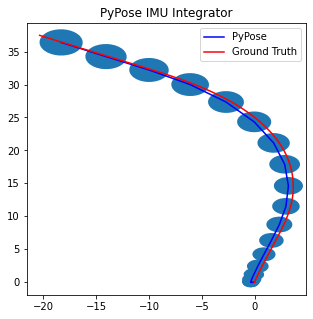

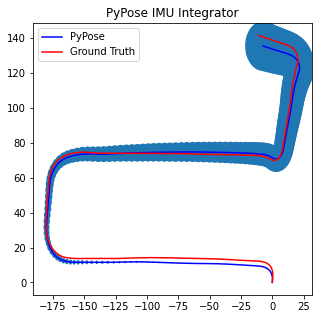

In [5]:
integrating_step, batch_size = 5, 1
device = 'cpu' # or 'cuda:0'
datadrive = ['0018', '0022']
dataroot, dataname = '.', '2011_09_26'

torch.set_default_tensor_type(torch.DoubleTensor)

for drive in datadrive:
    dataset = KITTI_IMU(dataroot, dataname, drive)
    p, r, v = dataset.init_value()
    integrator = pp.module.IMUPreintegrator(p, r, v).to(device)
    loader = Data.DataLoader(dataset=dataset, batch_size=batch_size)
    poses, poses_gt = [p.to(device)], [p.to(device)]
    covs = [torch.zeros(9, 9, device=device)]
    for idx, (dt, ang, acc, vel, rot, pos_gt) in enumerate(loader):
        dt,  ang = dt.to(device),  ang.to(device)
        acc, rot = acc.to(device), rot.to(device)
        poses_gt.append(pos_gt.to(device))
        integrator.update(dt, ang, acc, rot)
        if idx % integrating_step == 0:
            state = integrator()
            poses.append(state['pos'])
            covs.append(state['cov'])
    poses = torch.cat(poses).cpu().numpy()
    poses_gt = torch.cat(poses_gt).cpu().numpy()
    covs = torch.stack(covs).cpu().numpy()

    plt.figure(figsize=(5, 5))
    ax = plt.axes()
    ax.plot(poses[:,0], poses[:,1], 'b')
    ax.plot(poses_gt[:,0], poses_gt[:,1], 'r')
    plot_gaussian(ax, poses[:, 0:2], covs[:, 6:8,6:8])
    plt.title("PyPose IMU Integrator")
    plt.legend(["PyPose", "Ground Truth"])
    plt.show()